# <center> Ocean Temperature Analysis </center>
# <center> for the </center>
# <center> Pacific Climate Change Monitor (PCCM) </center>

***
Jim P. <br>
_January 2022_
***
<br>

This notebook is used to make figures for the Pacific Climate Change Monitor (PCCM) report, specifically those involving ocean temperature.  This includes sea surface temperature data (SST), depth of the 20-degree isotherm (as proxy for heat content), degree heating weeks (DHW) and Hot Spots (HS).  Data are read from three sources: SST from both the NOAA OI-SST product and the NOAA Coral Reef Watch (CRW) program, DHW/HS from CRW, and subsurface temperature from NOAA GODAS.

NOAA's OI-SST is a monthly SST product on a 1x1 degree grid.  Data are available from December 1981 through present.  Here we use the complete years 1982-2021.

http://apdrc.soest.hawaii.edu/dods/public_data/NOAA_SST/OISST/monthly.info

The CRW output is served by PacIOOS on both an ERDDAP and THREDDS server.  These are daily files on a 5 km grid, so it is a large amount of data. I first tried to access the daily CRW data from the PacIOOS THREDDS server, but this failed, I think because the data are such high resolution in space (5 km for the globe) and in time (daily for 30+ years).  So, I used NCO tools to produce monthly mean values, and then John M. added these to a separate TDS entry.  This works much better.

https://pae-paha.pacioos.hawaii.edu/thredds/satellite.html?dataset=dhw_5km_monthly

The subsurface temperature is from the NOAA GODAS reanalysis.  This has monthly mean data on a 1-degree longitude by 1/3-degree latitude grid for January 1980 through present.

http://apdrc.soest.hawaii.edu/dods/public_data/Reanalysis_Data/GODAS/monthly/potmp.info

The notebook reads in data and then computes linear trends and, where appropriate, aggregates.

In [1]:
# numerics
import numpy as np

# load in plotting routines
#   cm needed for other color maps
#   colors needed to offset color ranges (e.g., set middle value)
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors

# add mapping routines
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# add shape file packages
import geopandas as gpd
from cartopy.feature import ShapelyFeature
import cartopy.io.shapereader as shpreader

#  NOTE: this is needed to get the right PROJ directory; without it you'll 
#        see an error on missing EPSF projection.  For details, see 
#        https://pyproj4.github.io/pyproj/stable/gotchas.html#internal-proj-error-sqlite-error-on-select
#        To get data directory being used: pyproj.datadir.get_data_dir()
#        To change the data directory: pyproj.datadir.set_data_dir()
import pyproj
pyproj.datadir.set_data_dir('/opt/anaconda3/share/proj')

# working with OPeNDAP files
import netCDF4 as nc
import xarray as xr

# working with matlab binary files
import scipy.io

# import pandas for data handling and dates
import pandas as pd

# import datetime for date handling
import datetime as dt

# use this for progress bars (and use trange instead of range)
from tqdm.notebook import tqdm, trange

# get Nico's code for masking (and other stuff)
import sys
sys.path.append('/Users/jimp/Research/pccm/ICU_Water_Watch/')
from ICU_Water_Watch import geo

## 1. Set lat/lon ranges and input files

In [2]:
# 1. set ranges (specified by John Marra; 35S to 35N, 125E to 115W)
minlat = -35.0
maxlat = 35.0
minlon = 125.0
maxlon = 360.0-115.0

# 2. define some dates: the first one is for single panel plots,
#    the others are for the range over which means are computed
date_static = '1986-01-01'
date_static_t = 'Jan 1986'
crw_year1 = '1986'
crw_year2 = '2020'
oisst_year1 = '1982'
#oisst_year2 = '2021'
# match Grant's plots and use 2020
oisst_year2 = '2020'
godas_year1 = '1980'
godas_year2 = '2021'

# 3. specific OPeNDAP endpoints
#   2a. PacIOOS TDS catalogue for daily DHW/HS
crw_daily_url = 'https://pae-paha.pacioos.hawaii.edu/thredds/dodsC/dhw_5km'
#   2b. PacIOOS ERDDAP catalogue for daily DHW/HS
crw_erddap_url = 'https://pae-paha.pacioos.hawaii.edu/erddap/griddap/dhw_5km'
#   2c. PacIOOS ERDDAP catalogue for monthly mean DHW/HS, longitude rolled
crw_url = 'https://pae-paha.pacioos.hawaii.edu/erddap/griddap/dhw_5km_monthly_lon360'
#   2d. APDRC TDS catalogue for monthly mean OISST
oisst_url = 'http://apdrc.soest.hawaii.edu:80/dods/public_data/NOAA_SST/OISST/monthly'
#   2e. APDRC TDS catalogue for monthly mean GODAS
godas_url = 'http://apdrc.soest.hawaii.edu:80/dods/public_data/Reanalysis_Data/GODAS/monthly/potmp'

# 4. specify shapefile with EEZ polygons
# NOTE: the file Pacific_Island_EEZ_shifted has longitudes from -180 to 180
#       while Pacific_Island_EEZ has longitudes from 0 to 360.
#       The former requires a shift using Nico's geo tools, but does
#       NOT work with the plotting routines that show EEZ lines.  
shapefile180 = './shapefiles/Pacific_Island_EEZ_shifted.shp'
shapefile360 = './shapefiles/Pacific_Island_EEZ.shp'

## 2. Read data (EEZ's from shapefile, SST/DHW from OPeNDAP

In [3]:
# 1. load shapefile with EEZ's; here we read the boarders and country names
#    (the country names could be used on the plot, but as yet I don't use them)
#    NOTE: I had to reproject the original file that was -180 to 180 to 
#        be 0 to 360 (thus the '_shifted' in the file name).  The
#        reprojection was done with ogr2ogr:
#        ogr2ogr -s_srs EPSG:4326 -t_srs "+proj=longlat +ellps=WGS84 +pm=-180 +datum=WGS84 +no_defs" ...
#                  Pacific_Island_EEZ_shifted.shp Pacific_Island_EEZ.shp
shpf180 = gpd.read_file(shapefile180)
shpf180 = shpf180.loc[:,['COUNTRYNAM','geometry']]
shpf360 = gpd.read_file(shapefile360)
shpf360 = shpf360.loc[:,['COUNTRYNAM','geometry']]

# 2. read OPeNDAP data sets

# 2a. xarray (doesn't work with TDS url, but this is fastest and preferred)
#  The "decode_times=True" kwarg works fine with OI-SST (gets a good date)
crw = xr.open_dataset(crw_url, decode_times=True)
oisst = xr.open_dataset(oisst_url, decode_times=True)
godas = xr.open_dataset(godas_url, decode_times=True)
xr.set_options(display_style="html");

# 2b. netCDF with TDS
#   Note, this should just be nc.Dataset(URL), but I can an error on _FillValue mismatch
#   the solution was from https://github.com/Unidata/netcdf4-python/issues/929
#ds = nc.Dataset('[FillMismatch]' + url)

# 2c. netCDF with ERDDAP
#ds = nc.Dataset(url)

/opt/anaconda3/lib/python3.8/site-packages/xarray/coding/times.py:113: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:0.0. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:0.0). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


## 3. Make color-shaded map for one specific time as check

In [4]:
# 1. Slice the data for Pacific, single time

# NOTE:
# 1. CRW latitudes go backwards, so the slice is for example 23,21 and not 21,23 to get 21N to 23N
# 2. longitudes were reprojected in this example to run 0 to 360 (use other URL for -180 to 180)
# 3. CRW times are floating points 'seconds since 1981-01-01 00:00:00'; 
#    the first time is 4.812048e+08 (April 1, 1985)
# 4. values are monthly means

# CRW data
sst_crw = crw['CRW_SST'].loc[{'latitude': slice(maxlat,minlat),
                             'longitude': slice(minlon,maxlon), 
                                  'time': slice(date_static,date_static)}]
dhw = crw['CRW_DHW'].loc[{'latitude': slice(maxlat,minlat),
                         'longitude': slice(minlon,maxlon), 
                              'time': slice(date_static,date_static)}]
hs = crw['CRW_HOTSPOT'].loc[{'latitude': slice(maxlat,minlat),
                            'longitude': slice(minlon,maxlon), 
                                 'time': slice(date_static,date_static)}]
# OISST data
sst_oisst = oisst['sst'].loc[{'lat': slice(minlat,maxlat),
                              'lon': slice(minlon,maxlon), 
                             'time': slice(date_static,date_static)}]

# GODAS data
sst_godas = godas['potdsl'].loc[{'lat': slice(minlat,maxlat),
                                 'lon': slice(minlon,maxlon),
                                 'lev': slice(5,5),
                                'time': slice(date_static,date_static)}]

# get all times (takes a while)
#sst = ds['CRW_SST'].loc[{'latitude': slice(maxlat,minlat),'longitude': slice(minlon,maxlon)}]
#dhw = ds['CRW_DHW'].loc[{'latitude': slice(maxlat,minlat),'longitude': slice(minlon,maxlon)}]

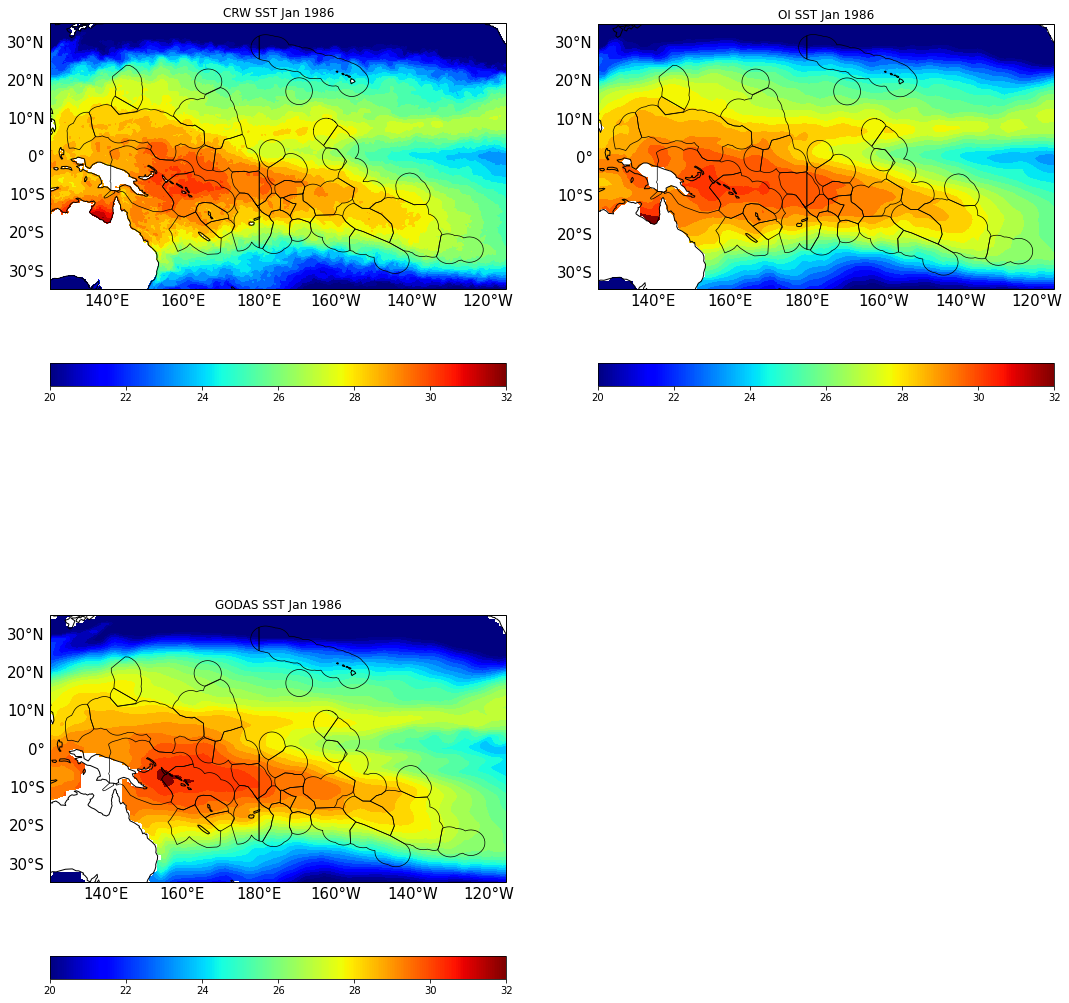

In [5]:
# set up the figure
fig = plt.subplots( figsize = (18, 20) )

# set color range
vmin, vmax = 20, 32

# 1. Plot CRW (sst_crw)
# set projection, center on the Pacific
ax1 = plt.subplot(2,2,1,projection = ccrs.PlateCarree(central_longitude=180.0))

# add coastlines
ax1.add_feature(cf.COASTLINE)

# add lat/lon labels (left and bottom)
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0, color='gray',
                alpha=0.75, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

# set label size and color
gl.xlabel_style = {'size':15, 'color': 'black'}
gl.ylabel_style = {'size':15, 'color': 'black'}

# specify where to label
gl.xlocator = mticker.FixedLocator([140, 160, 180, -160, -140, -120])
gl.ylocator = mticker.FixedLocator([-30, -20, -10, 0, 10, 20, 30])

# specify how to label
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# plot variable
ctf = plt.contourf(sst_crw['longitude'], sst_crw['latitude'], sst_crw.squeeze(), 50,
             vmin=vmin, vmax=vmax, cmap=cm.jet, extend='both', transform=ccrs.PlateCarree())

# add EEZ's as black lines
for i, row in shpf180.iterrows():
    geom = row.geometry
    sp = ShapelyFeature([geom],ccrs.PlateCarree(central_longitude=180.0),
                        edgecolor='black',facecolor='none',lw=0.7)
    ax1.add_feature(sp)

# Add a colorbar and title
#plt.colorbar(ctf,orientation='horizontal',ax=ax1)
plt.colorbar(cm.ScalarMappable(norm = ctf.norm, cmap = ctf.cmap),orientation='horizontal',
             ticks = range(vmin,vmax+2,2))
plt.title('CRW SST ' + date_static_t)

# 2. Plot OISST
# set projection, center on the Pacific
ax2 = plt.subplot(2,2,2,projection = ccrs.PlateCarree(central_longitude=180.0))

# add coastlines
ax2.add_feature(cf.COASTLINE)

# add lat/lon labels (left and bottom)
gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0, color='gray',
                alpha=0.75, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

# set label size and color
gl.xlabel_style = {'size':15, 'color': 'black'}
gl.ylabel_style = {'size':15, 'color': 'black'}

# specify where to label
gl.xlocator = mticker.FixedLocator([140, 160, 180, -160, -140, -120])
gl.ylocator = mticker.FixedLocator([-30, -20, -10, 0, 10, 20, 30])

# specify how to label
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# plot variable
ctf = plt.contourf(sst_oisst['lon'], sst_oisst['lat'], sst_oisst.squeeze(), 50,
             vmin=vmin,vmax=vmax, cmap=cm.jet, extend = 'both', transform=ccrs.PlateCarree())

# add EEZ's as black lines
for i, row in shpf180.iterrows():
    geom = row.geometry
    sp = ShapelyFeature([geom],ccrs.PlateCarree(central_longitude=180.0),
                        edgecolor='black',facecolor='none',lw=0.7)
    ax2.add_feature(sp)

# Add a colorbar and title
#plt.colorbar(ctf,orientation='horizontal',ax=ax2)
plt.colorbar(cm.ScalarMappable(norm = ctf.norm, cmap = ctf.cmap),orientation='horizontal',
             ticks = range(vmin,vmax+2,2))
plt.title('OI SST ' + date_static_t)

# 3. Plot GODAS SST (sst_godas)
# set projection, center on the Pacific
ax3 = plt.subplot(2,2,3,projection = ccrs.PlateCarree(central_longitude=180.0))

# add coastlines
ax3.add_feature(cf.COASTLINE)

# add lat/lon labels (left and bottom)
gl = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0, color='gray',
                alpha=0.75, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

# set label size and color
gl.xlabel_style = {'size':15, 'color': 'black'}
gl.ylabel_style = {'size':15, 'color': 'black'}

# specify where to label
gl.xlocator = mticker.FixedLocator([140, 160, 180, -160, -140, -120])
gl.ylocator = mticker.FixedLocator([-30, -20, -10, 0, 10, 20, 30])

# specify how to label
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# plot variable
ctf = plt.contourf(sst_godas['lon'], sst_godas['lat'], sst_godas.squeeze()-273.15, 50,
             vmin=vmin, vmax=vmax, cmap=cm.jet, extend='both', transform=ccrs.PlateCarree())

# add EEZ's as black lines
for i, row in shpf180.iterrows():
    geom = row.geometry
    sp = ShapelyFeature([geom],ccrs.PlateCarree(central_longitude=180.0),
                        edgecolor='black',facecolor='none',lw=0.7)
    ax3.add_feature(sp)

# Add a colorbar and title
#plt.colorbar(ctf,orientation='horizontal',ax=ax1)
plt.colorbar(cm.ScalarMappable(norm = ctf.norm, cmap = ctf.cmap),orientation='horizontal',
             ticks = range(vmin,vmax+2,2))
plt.title('GODAS SST ' + date_static_t);

# Save as png image
plt.savefig('sst_comparison.png', format='png',dpi=300,facecolor='white')

## 4. Compute and plot trends over the region

### 4.1 CRW data
This should work directly within xarray, but for some reason the DHW dataset takes over 48 hours and still did not complete.  Instead, I ran this in matlab, and then saved the output. Also worth noting that it took forever on matlab, until I went point by point. This code runs in about 10 minutes; if you instead try read all times in the ncread command (instead of in a loop), it runs for hours and hours.

    url_erd = 'https://pae-paha.pacioos.hawaii.edu/erddap/griddap/dhw_5km_monthly_lon0360';
    lat_erd = ncread(url_erd,'latitude');
    lon_erd = ncread(url_erd,'longitude');
    lat1_erd = find(lat_erd >= 34.95 & lat_erd <= 35.0 );
    lat2_erd = find(lat_erd >= -35.0 & lat_erd <= -34.95 );
    lon1_erd = find(lon_erd >= 125.0 & lon_erd <= 125.05 );
    lon2_erd = find(lon_erd >= 360-115.05 & lon_erd <= 360-115.0);
    dwh = NaN(lon2_erd-lon1_erd+1,lat2_erd-lat1_erd+1,420);
    for k = 10:429
      k-9
      dwh(:,:,k-9) = ncread(url_erd,'CRW_DHW',[lon1_erd,lat1_erd,k],[lon2_erd-lon1_erd+1,lat2_erd-lat1_erd+1,1]);
    end
    X = [1:420];
    nlon = lon2_erd - lon1_erd + 1;
    nlat = lat2_erd - lat1_erd + 1;
    trend = NaN(nlon,nlat);
    for I = 1:nlon
       for J = 1:nlat
          Y = squeeze(dwh(I,J,:))';
          B = polyfit(X,Y,1);
          if( ~isnan(Y(1)) )
             trend(I,J) = B(1);
          end
       end
    end
    save('dwh_trend.mat','trend');

In [6]:
# Read the trend data
mdf = scipy.io.loadmat('sst_trend.mat')
crwsst_trend = mdf['trend'].transpose()
mdf = scipy.io.loadmat('dhw_trend.mat')
dhw_trend = mdf['trend'].transpose()

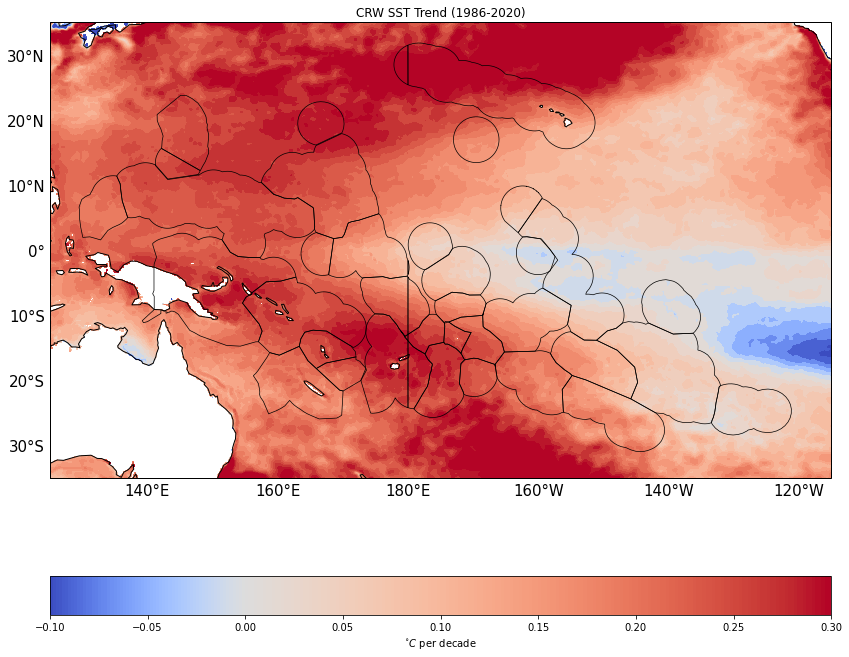

In [7]:
# Make the plot
fig = plt.figure( figsize = (14, 12) )
vmin, vmax = -0.1, 0.3

# set projection, center on the Pacific
ax = plt.axes(projection = ccrs.PlateCarree(central_longitude=180.0))

divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0., vmax=vmax)

# color-shade sea level ('data') on same projection
# convert the CRW slope from degC/month to degC/decade (*120.0)
ctf = plt.contourf(sst_crw['longitude'], sst_crw['latitude'], crwsst_trend*120.0, 50,
#             vmin=-0.1,vmax=0.5, cmap=cm.jet, transform=ccrs.PlateCarree())
#             vmin=vmin,vmax=vmax, cmap=cm.bwr, transform=ccrs.PlateCarree())
#                   vmin=vmin,vmax=vmax, cmap=cm.YlOrRd, transform=ccrs.PlateCarree())
                   norm=divnorm, cmap=cm.coolwarm, transform=ccrs.PlateCarree())

# add coastlines
ax.add_feature(cf.COASTLINE)

# add lat/lon labels (left and bottom)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0, color='gray',
                alpha=0.75, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

# set label size and color
gl.xlabel_style = {'size':15, 'color': 'black'}
gl.ylabel_style = {'size':15, 'color': 'black'}

# specify where to label
gl.xlocator = mticker.FixedLocator([140, 160, 180, -160, -140, -120])
gl.ylocator = mticker.FixedLocator([-30, -20, -10, 0, 10, 20, 30])

# specify how to label
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# add EEZ's as black lines
for i, row in shpf180.iterrows():
    geom = row.geometry
    sp = ShapelyFeature([geom],ccrs.PlateCarree(central_longitude=180.0),edgecolor='black',
                        facecolor='none',lw=0.7)
    ax.add_feature(sp)

# Add a colorbar and title
plt.colorbar(cm.ScalarMappable(norm = ctf.norm, cmap = ctf.cmap),orientation='horizontal',
             label='$^{\circ}C$ per decade')

plt.title('CRW SST Trend (' + crw_year1 + '-' + crw_year2 + ')')
plt.savefig('sst_trend_crw.png', format='png',dpi=300,facecolor='white')

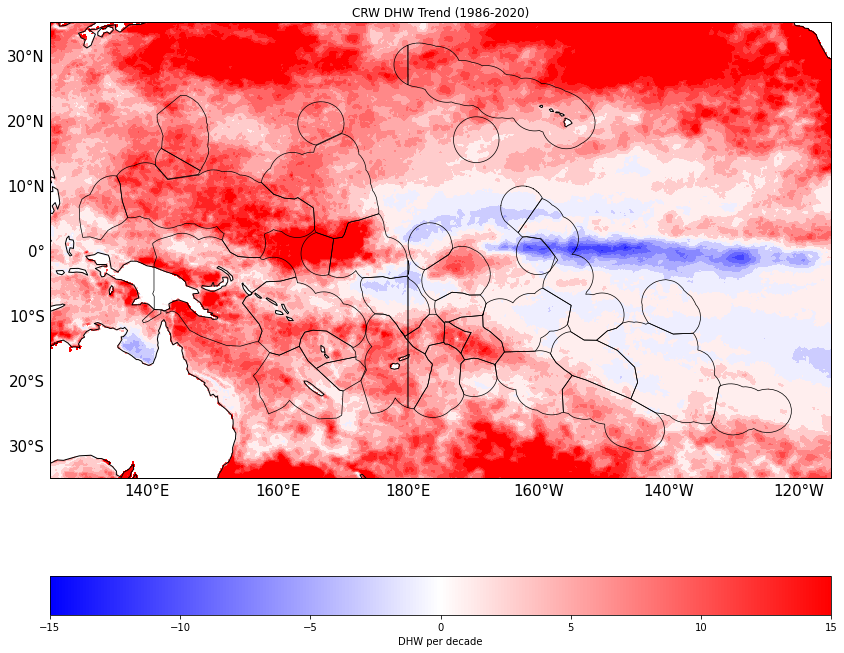

In [8]:
# Make the figure
fig = plt.figure( figsize = (14, 12) )

# define color range
vmin, vmax = -15.0, 15.0

# set projection, center on the Pacific
ax = plt.axes(projection = ccrs.PlateCarree(central_longitude=180.0))
    
# color-shade sea level ('data') on same projection
# convert from monthly means to daily, assume 30.5 days a month, and the decades
ctf = plt.contourf(sst_crw['longitude'], sst_crw['latitude'], dhw_trend*120.0*30.5, 50,
#                   vmin=vmin,vmax=vmax, cmap=cm.jet, transform=ccrs.PlateCarree())
                   vmin=vmin,vmax=vmax, cmap=cm.bwr, transform=ccrs.PlateCarree())

# add coastlines
ax.add_feature(cf.COASTLINE)

# add lat/lon labels (left and bottom)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0, color='gray',
                alpha=0.75, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

# set label size and color
gl.xlabel_style = {'size':15, 'color': 'black'}
gl.ylabel_style = {'size':15, 'color': 'black'}

# specify where to label
gl.xlocator = mticker.FixedLocator([140, 160, 180, -160, -140, -120])
gl.ylocator = mticker.FixedLocator([-30, -20, -10, 0, 10, 20, 30])

# specify how to label
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# add EEZ's as black lines
for i, row in shpf180.iterrows():
    geom = row.geometry
    sp = ShapelyFeature([geom],ccrs.PlateCarree(central_longitude=180.0),
                        edgecolor='black',facecolor='none',lw=0.7)
    ax.add_feature(sp)

# Add a colorbar and title
plt.colorbar(cm.ScalarMappable(norm = ctf.norm, cmap = ctf.cmap),orientation='horizontal',
             label='DHW per decade')


plt.title('CRW DHW Trend ('+crw_year1+'-'+crw_year2+')')
plt.savefig('dhw_trend.png', format='png',dpi=300,facecolor='white')

### 4.2 OI-SST data

In [9]:
# Read the data
sst_oisst = oisst['sst'].loc[{'lat': slice(minlat,maxlat),
                              'lon': slice(minlon,maxlon), 
                             'time': slice('01-01-'+oisst_year1,'12-31-'+oisst_year2)}]
sstfit = sst_oisst.polyfit('time',1)
# Note the trend is the second coefficient so we just get that;
# also, the return, since we pass datatime, is in ns (!)
oisst_trend = sstfit['polyfit_coefficients'].loc[1]

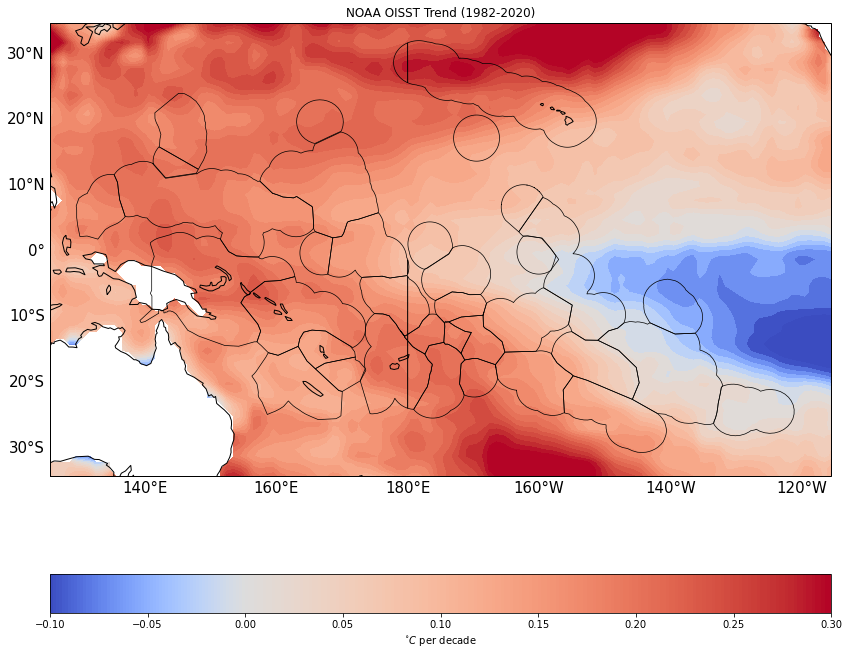

In [10]:
# Make the figure
fig = plt.figure( figsize = (14, 12) )
vmin, vmax = -0.1, 0.3
divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0., vmax=vmax)

# set projection, center on the Pacific
ax = plt.axes(projection = ccrs.PlateCarree(central_longitude=180.0))
    
# color-shade sea level ('data') on same projection
# convert the SST trend from degC/nanosecond to degC/decade)
ctf = plt.contourf(sst_oisst['lon'], sst_oisst['lat'], oisst_trend*10.0*365.0*86400.0*1e9, 50,
#             vmin=vmin,vmax=vmax, cmap=cm.bwr, transform=ccrs.PlateCarree())
#                   vmin=vmin,vmax=vmax, cmap=cm.YlOrRd, transform=ccrs.PlateCarree())
              norm=divnorm, cmap=cm.coolwarm, transform=ccrs.PlateCarree())
# add coastlines
ax.add_feature(cf.COASTLINE)

# add lat/lon labels (left and bottom)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0, color='gray',
                alpha=0.75, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

# set label size and color
gl.xlabel_style = {'size':15, 'color': 'black'}
gl.ylabel_style = {'size':15, 'color': 'black'}

# specify where to label
gl.xlocator = mticker.FixedLocator([140, 160, 180, -160, -140, -120])
gl.ylocator = mticker.FixedLocator([-30, -20, -10, 0, 10, 20, 30])

# specify how to label
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# add EEZ's as black lines
for i, row in shpf180.iterrows():
    geom = row.geometry
    sp = ShapelyFeature([geom],ccrs.PlateCarree(central_longitude=180.0),
                        edgecolor='black',facecolor='none',lw=0.7)
    ax.add_feature(sp)

# Add a colorbar and title
#cbar = plt.colorbar(orientation='horizontal')
#cbar.set_label('$^{\circ}C$ per decade')
plt.colorbar(cm.ScalarMappable(norm = ctf.norm, cmap = ctf.cmap),orientation='horizontal',
             label='$^{\circ}C$ per decade')

plt.title('NOAA OISST Trend ('+oisst_year1+'-'+oisst_year2+')')
plt.savefig('sst_trend_oisst.png', format='png',dpi=300,facecolor='white')

### 4.3 GODAS SST data

In [11]:
# Read the data
sst_godas = godas['potdsl'].loc[{'lat': slice(minlat,maxlat),
                                 'lon': slice(minlon,maxlon), 
                                 'lev': slice(5,5),
                                'time': slice('01-01-'+godas_year1,'12-31-'+godas_year2)}]
sstfit = sst_godas.polyfit('time',1)
# Note the trend is the second coefficient so we just get that;
# also, the return, since we pass datatime, is in ns (!)
godas_trend = sstfit['polyfit_coefficients'].loc[1]

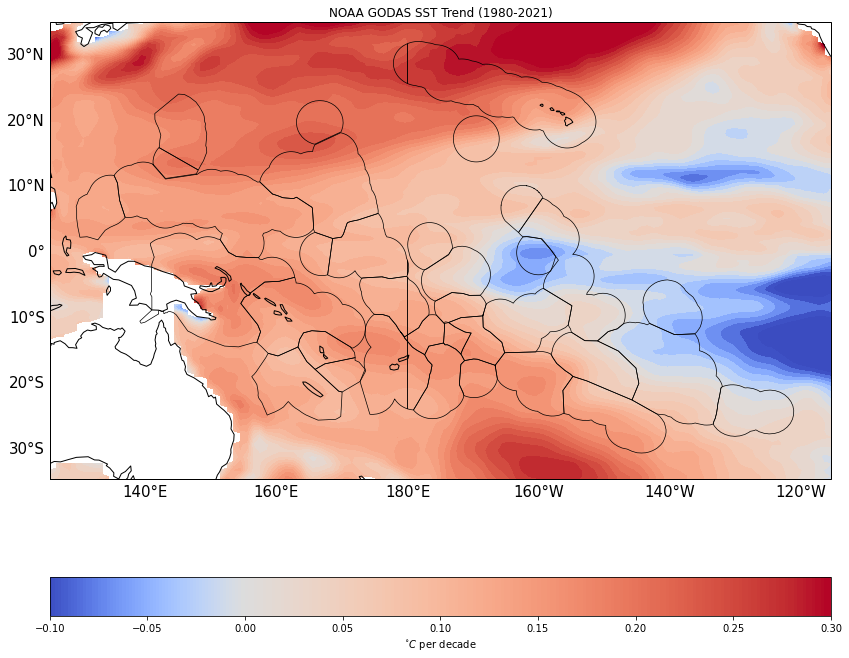

In [12]:
# Make the figure
fig = plt.figure( figsize = (14, 12) )
vmin, vmax = -0.1, 0.3
divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0., vmax=vmax)

# set projection, center on the Pacific
ax = plt.axes(projection = ccrs.PlateCarree(central_longitude=180.0))
    
# color-shade sea level ('data') on same projection
# convert the SST trend from degC/nanosecond to degC/decade)
ctf = plt.contourf(sst_godas['lon'], sst_godas['lat'], 
                   godas_trend.squeeze()*10.0*365.0*86400.0*1e9, 50,
#             vmin=vmin,vmax=vmax, cmap=cm.bwr, transform=ccrs.PlateCarree())
#                   vmin=vmin,vmax=vmax, cmap=cm.YlOrRd, transform=ccrs.PlateCarree())
              norm=divnorm, cmap=cm.coolwarm, transform=ccrs.PlateCarree())
# add coastlines
ax.add_feature(cf.COASTLINE)

# add lat/lon labels (left and bottom)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0, color='gray',
                alpha=0.75, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

# set label size and color
gl.xlabel_style = {'size':15, 'color': 'black'}
gl.ylabel_style = {'size':15, 'color': 'black'}

# specify where to label
gl.xlocator = mticker.FixedLocator([140, 160, 180, -160, -140, -120])
gl.ylocator = mticker.FixedLocator([-30, -20, -10, 0, 10, 20, 30])

# specify how to label
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# add EEZ's as black lines
for i, row in shpf180.iterrows():
    geom = row.geometry
    sp = ShapelyFeature([geom],ccrs.PlateCarree(central_longitude=180.0),
                        edgecolor='black',facecolor='none',lw=0.7)
    ax.add_feature(sp)

# Add a colorbar and title
#cbar = plt.colorbar(orientation='horizontal')
#cbar.set_label('$^{\circ}C$ per decade')
plt.colorbar(cm.ScalarMappable(norm = ctf.norm, cmap = ctf.cmap),orientation='horizontal',
             label='$^{\circ}C$ per decade')

plt.title('NOAA GODAS SST Trend ('+godas_year1+'-'+godas_year2+')')
plt.savefig('sst_trend_godas.png', format='png',dpi=300,facecolor='white')

## 5. Compute and plot trends averaged by EEZ

### 5.1 CRW data

In [13]:
# convert CRW data as read (numpy array from matlab file) to xarray DataArray
crwsst_trendX = xr.DataArray(crwsst_trend,coords=[sst_crw['latitude'],sst_crw['longitude']],dims=['lat','lon'])
sst_invert = crwsst_trendX.sortby('lat')
A = pd.DataFrame()
for location in shpf180.COUNTRYNAM.unique():
    if location != 'Federated States of Micronesia':
        shape = shpf180.query(f"COUNTRYNAM == '{location}'")
        shape_shifted = geo.shift_geom(-180, shape)
        sst_mask = geo.make_mask_from_gpd(sst_invert, shape_shifted, lon_name='lon', 
                                        lat_name='lat', subset=True, mask_name=location)
        sst_eez = sst_invert * sst_mask[location]
        sst_ave_eez = sst_eez.mean(dim=['lat','lon'])
        A = A.append(pd.DataFrame([[location,sst_ave_eez.values.astype(float)]],
                                      columns=['Location','trend']),ignore_index=True)

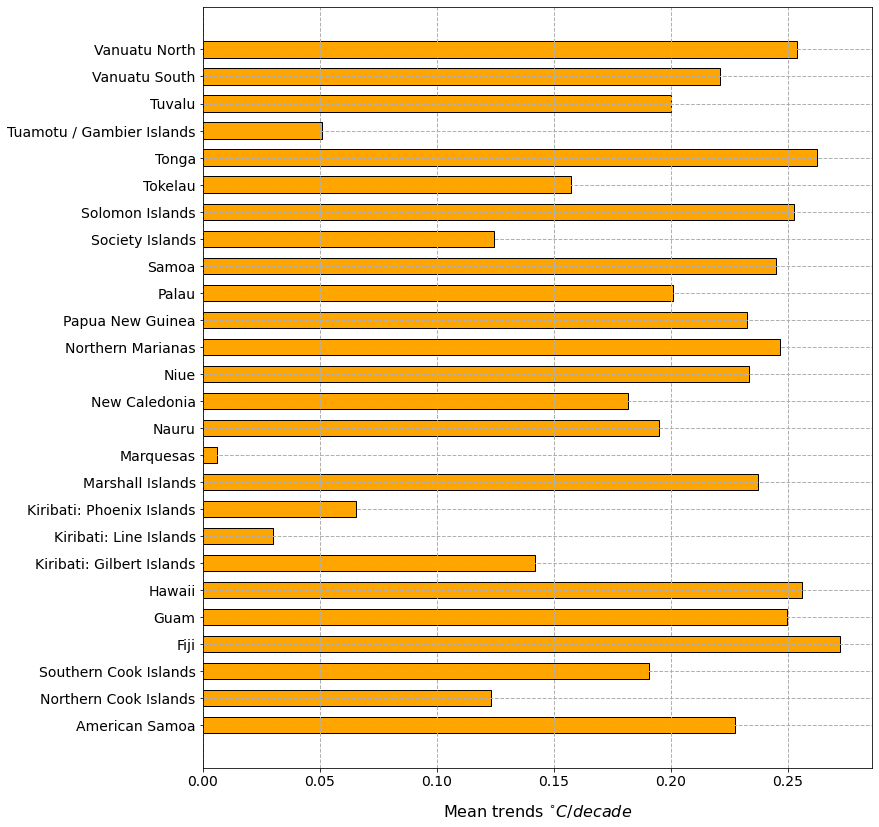

In [14]:
# trends in degC/nanosec, change to decade
ns2dec = 10.0 * 365.25 * 86400.0 * 1e9
locations = [ 'American Samoa', 'Northern Cook Islands', 'Southern Cook Islands', 
               'Fiji', 'Guam', 'Hawaii', 'Kiribati: Gilbert Islands', 
              'Kiribati: Line Islands', 'Kiribati: Phoenix Islands', 'Marshall Islands', 'Marquesas', 
              'Nauru', 'New Caledonia', 'Niue', 'Northern Marianas', 'Papua New Guinea', 'Palau', 'Samoa', 
              'Society Islands', 'Solomon Islands', 'Tokelau', 'Tonga', 'Tuamotu / Gambier Islands', 
              'Tuvalu', 'Vanuatu South', 'Vanuatu North' ]
x = np.arange(len(locations))  # the label locations
tall = [], [], []
for loc in locations:
    i = A[A['Location'] == loc].index
    tall = np.append(tall,120.0*A['trend'][i].values)
width = 0.6  # the width of the bars

fig, ax = plt.subplots( figsize = (12, 14) )
ax = plt.barh(x,tall,align='center', color='orange', height=width, edgecolor='black')
plt.yticks(x,locations)
plt.tick_params(axis='both', labelsize=14)
plt.xlabel('Mean trends $^{\circ}C/decade$', fontsize = 16, labelpad =14)
#plt.xticks(rotation='vertical')
plt.grid(linestyle='dashed', linewidth=1, zorder=0)
plt.savefig('sst_trend_eez_crwsst.png', format='png',dpi=300,facecolor='white')

### 5.2 OISST

In [15]:
sst_invert = oisst_trend.sortby('lat')
A = pd.DataFrame()
for location in shpf180.COUNTRYNAM.unique():
    if location != 'Federated States of Micronesia':
        shape = shpf180.query(f"COUNTRYNAM == '{location}'")
        shape_shifted = geo.shift_geom(-180, shape)
        sst_mask = geo.make_mask_from_gpd(sst_invert, shape_shifted, lon_name='lon', 
                                        lat_name='lat', subset=True, mask_name=location)
        sst_eez = sst_invert * sst_mask[location]
        sst_ave_eez = sst_eez.mean(dim=['lat','lon'])
        A = A.append(pd.DataFrame([[location,sst_ave_eez.values.astype(float)]],
                                      columns=['Location','trend']),ignore_index=True)

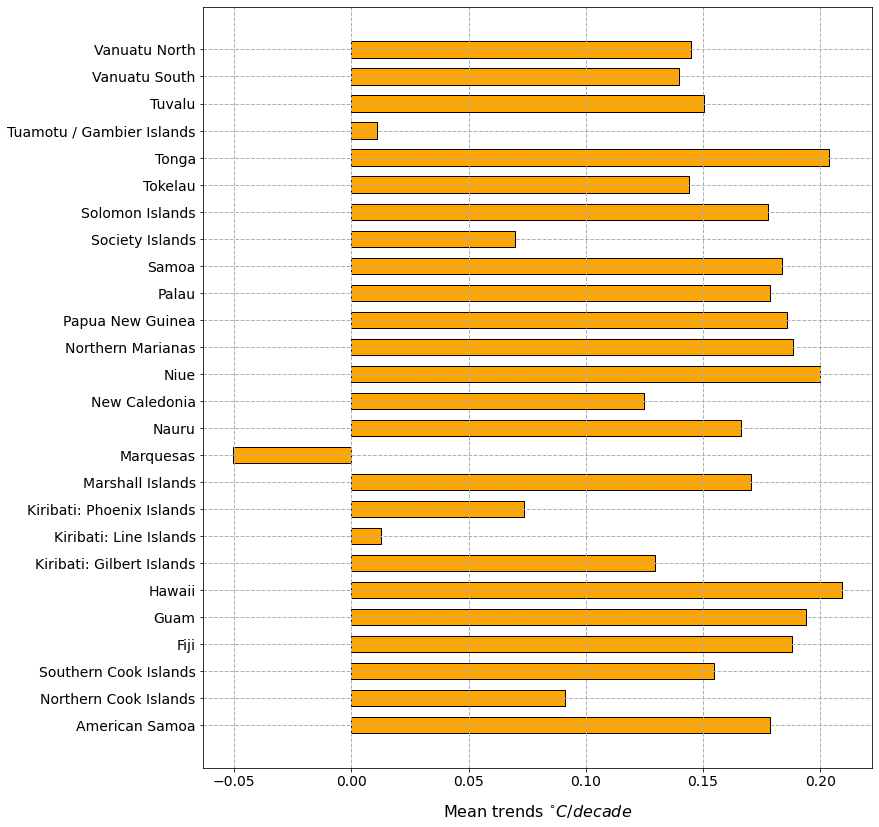

In [16]:
# trends in degC/nanosec, change to decade
ns2dec = 10.0 * 365.25 * 86400.0 * 1e9
locations = [ 'American Samoa', 'Northern Cook Islands', 'Southern Cook Islands', 
               'Fiji', 'Guam', 'Hawaii', 'Kiribati: Gilbert Islands', 
              'Kiribati: Line Islands', 'Kiribati: Phoenix Islands', 'Marshall Islands', 'Marquesas', 
              'Nauru', 'New Caledonia', 'Niue', 'Northern Marianas', 'Papua New Guinea', 'Palau', 'Samoa', 
              'Society Islands', 'Solomon Islands', 'Tokelau', 'Tonga', 'Tuamotu / Gambier Islands', 
              'Tuvalu', 'Vanuatu South', 'Vanuatu North' ]
x = np.arange(len(locations))  # the label locations
tall = [], [], []
for loc in locations:
    i = A[A['Location'] == loc].index
    tall = np.append(tall,ns2dec*A['trend'][i].values)
width = 0.6  # the width of the bars

fig, ax = plt.subplots( figsize = (12, 14) )
ax = plt.barh(x,tall,align='center', color='orange', height=width, edgecolor='black')
plt.yticks(x,locations)
plt.tick_params(axis='both', labelsize=14)
plt.xlabel('Mean trends $^{\circ}C/decade$', fontsize = 16, labelpad =14)
#plt.xticks(rotation='vertical')
plt.grid(linestyle='dashed', linewidth=1, zorder=0)
plt.savefig('sst_trend_eez_oisst.png', format='png',dpi=300,facecolor='white')

### 5.3 GODAS

In [17]:
sst_invert = godas_trend.sortby('lat').squeeze()
B = pd.DataFrame()
for location in shpf180.COUNTRYNAM.unique():
    if location != 'Federated States of Micronesia':
        shape = shpf180.query(f"COUNTRYNAM == '{location}'")
        shape_shifted = geo.shift_geom(-180, shape)
        sst_mask = geo.make_mask_from_gpd(sst_invert, shape_shifted, lon_name='lon', 
                                        lat_name='lat', subset=True, mask_name=location)
        sst_eez = sst_invert * sst_mask[location]
        sst_ave_eez = sst_eez.mean(dim=['lat','lon'])
        B = B.append(pd.DataFrame([[location,sst_ave_eez.values.astype(float)]],
                                      columns=['Location','trend']),ignore_index=True)

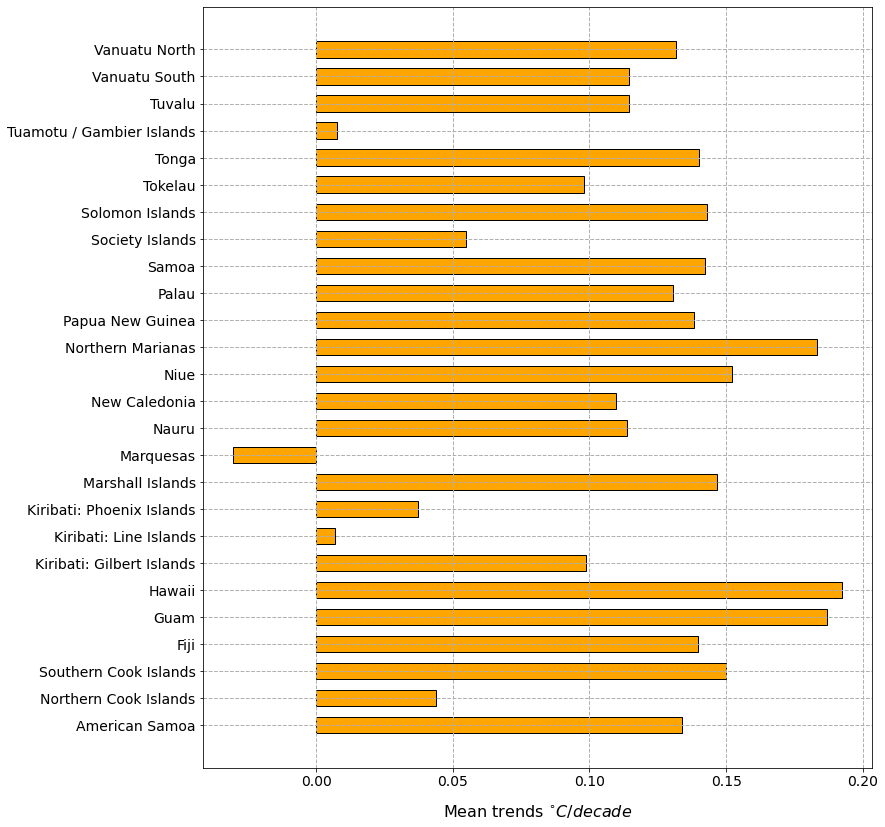

In [18]:
# trends in degC/nanosec, change to decade
ns2dec = 10.0 * 365.25 * 86400.0 * 1e9
locations = [ 'American Samoa', 'Northern Cook Islands', 'Southern Cook Islands', 
               'Fiji', 'Guam', 'Hawaii', 'Kiribati: Gilbert Islands', 
              'Kiribati: Line Islands', 'Kiribati: Phoenix Islands', 'Marshall Islands', 'Marquesas', 
              'Nauru', 'New Caledonia', 'Niue', 'Northern Marianas', 'Papua New Guinea', 'Palau', 'Samoa', 
              'Society Islands', 'Solomon Islands', 'Tokelau', 'Tonga', 'Tuamotu / Gambier Islands', 
              'Tuvalu', 'Vanuatu South', 'Vanuatu North' ]
x = np.arange(len(locations))  # the label locations
tall = [], [], []
for loc in locations:
    i = B[B['Location'] == loc].index
    tall = np.append(tall,ns2dec*B['trend'][i].values)
width = 0.6  # the width of the bars

fig, ax = plt.subplots( figsize = (12, 14) )
ax = plt.barh(x,tall,align='center', color='orange', height=width, edgecolor='black')
plt.yticks(x,locations)
plt.tick_params(axis='both', labelsize=14)
plt.xlabel('Mean trends $^{\circ}C/decade$', fontsize = 16, labelpad =14)
#plt.xticks(rotation='vertical')
plt.grid(linestyle='dashed', linewidth=1, zorder=0)
plt.savefig('sst_trend_eez_godas.png', format='png',dpi=300,facecolor='white')



## 6. Compute trends in integrated DHW and Hot Spots

Here we use the monthly mean DHW and Hot Spots and integrate over a year. This presumably gives us the total number of DHW in a year (note I multiply by 30.5 to get days).  Recall that a DHW is the number of days the SST exceeds the summer maximum times the number of days, so for example if the SST is one degree above the monthly climatological maximum for five days, this would be five DHW (1x5).  Below is an attempt to see if the total number of daily DHWs is increasing from year to year.

### 6.1 Compute the annually integrated DHW for each year
 <font color='red'>NOTE: This takes a long while, maybe 45 minutes or so, even though using monthly mean data</font>

In [19]:
hs_integrated = xr.DataArray()
z = crw['CRW_HOTSPOT'][0:12]

In [20]:
z_count = z.where(crw>=0 and crw<1).resample('AS','time',how='sum')

RuntimeError: NetCDF: Access failure

In [ ]:
# Compute the sum of DHW over a year.  Here we loop through all 36 years (1986-2021)
# NOTE that the daily data start in April 1985, but the monthly means start Jan 1986

#dhw = y.loc[{'latitude': slice(maxlat,minlat),'longitude': slice(minlon,maxlon)}]
#dhw_integrated = dhw.sum(dim='time')
dhw_integrated = xr.DataArray()
hs_integrated = xr.DataArray()
for k in trange (36):
    k1 =  ( k ) * 12
    k2 = k1 + 11
    # strip the 12 months of the kth year, convert to days by assuming 30.5 days a month
    y = crw['CRW_DHW'][k1:k2] * 30.5
    z = crw['CRW_HOTSPOT'][k1:k2] * 30.5
    # strip the Pacific lat/lon subregion
    dhw = y.loc[{'latitude': slice(maxlat,minlat), 'longitude': slice(minlon,maxlon)}]
    hs = z.loc[{'latitude': slice(maxlat,minlat), 'longitude': slice(minlon,maxlon)}]

    # integrate over all twelve months of the year
    dhw_sum = dhw.sum(dim='time')
    hs_sum = hs.sum(dim='time')
    dhw_integrated = xr.concat([dhw_integrated,dhw_sum],'year')
    hs_integrated = xr.concat([hs_integrated,hs_sum],'year')

We now have an xarray core-dataarray, dhw_integrated, that has three dimensions:
  * time: 37 annual accumulations <font color='red'>NOTE: the first time is NaN, so the valid range is 1986-2021 (36 points)</font>
  * latitude: 1400
  * longitude: 240

### 5.2 Compute the trend in the annually integrated DHW
 

In [ ]:
# Do linear fit
dhwfit = dhw_integrated.polyfit('year',1)
dhwtrend = dhwfit['polyfit_coefficients'].loc[1]
hsfit = hs_integrated.polyfit('year',1)
hstrend = hsfit['polyfit_coefficients'].loc[1]
#fig, ax = plt.subplots(figsize=(14,14))
#plt.contourf(trend['longitude'],trend['latitude'],trend)
#plt.colorbar() 

### 5.3 Compute the mean trend for each polygon (country EEZ)

In this first part we do an example for a single country and plot the mean DHW over the countries EEZ as a function of time (again, these are annual sums, so there is one value per year).


In [ ]:
# Example for a single country
country = 'Fiji'

# get polygon for single country
shape = shpf180.query("COUNTRYNAM == '"+country+"'")
# shift longitudes (-180 to 180 shifted to 0 to 360)
shape_shifted = geo.shift_geom(-180, shape)

# plot pre-shifted boundary
shape.boundary.plot()

# plot post-shifted boundary
shape_shifted.boundary.plot()

# Invert latitudes
idhw_invert = dhw_integrated.sortby('latitude')
ihs_invert = hs_integrated.sortby('latitude')

# Mask by EEZ
idhw_mask = geo.make_mask_from_gpd(idhw_invert, shape_shifted, lon_name='longitude', 
                             lat_name='latitude', subset=True, mask_name=country)
ihs_mask = geo.make_mask_from_gpd(ihs_invert, shape_shifted, lon_name='longitude', 
                             lat_name='latitude', subset=True, mask_name=country)
A = idhw_invert * idhw_mask[country]
Amean = A.mean(dim=['latitude','longitude'])
B = ihs_invert * ihs_mask[country]
Bmean = B.mean(dim=['latitude','longitude'])

# Plot the trend as a 
fig = plt.subplots(figsize=(12,8))
year=np.arange(1985,2021+1)
plt.plot(year,Amean,label='DHW')
plt.plot(year,Bmean,label='Hot Spot')
plt.title('Annually integrated DHW/HOTSPOT for ' + country)
plt.grid()
plt.legend()

### 5.4 Trends for each country as defined in shapefile

Now we compute the average trend over each country's EEZ.

In [ ]:
dhwtrend_invert = dhwtrend.sortby('latitude')
hstrend_invert = hstrend.sortby('latitude')
# for some reason the 9th entry, "Federated States of Micronesia" returns
# an empty GeoDataFrame, so for now just skip it
for i in trange(36):
    if i != 9:
        location = shpf180['COUNTRYNAM'][i]
        shape = shpf180.query("COUNTRYNAM == '"+location+"'")
        shape_shifted = geo.shift_geom(-180, shape)
        dhwtrend_mask = geo.make_mask_from_gpd(dhwtrend_invert, shape_shifted, lon_name='longitude', 
                                            lat_name='latitude', 
                                            subset=True, mask_name=location)
        dhwtrend_eez = dhwtrend_invert * dhwtrend_mask[location]
        dhwtrend_ave = dhwtrend_eez.mean(dim=['latitude','longitude'])
        hstrend_mask = geo.make_mask_from_gpd(hstrend_invert, shape_shifted, lon_name='longitude', 
                                            lat_name='latitude', 
                                            subset=True, mask_name=location)
        hstrend_eez = hstrend_invert * hstrend_mask[location]
        hstrend_ave = hstrend_eez.mean(dim=['latitude','longitude'])
        # take the trend averaged over each EEZ and add it to a pandas DataFrame
        if i == 0:
            A = pd.DataFrame([[location,dhwtrend_ave.values.astype(float)]],columns=['Location','Trend'])
            B = pd.DataFrame([[location,hstrend_ave.values.astype(float)]],columns=['Location','Trend'])
        else:
            A = A.append(pd.DataFrame([[location,dhwtrend_ave.values.astype(float)]],
                                      columns=['Location','Trend']),ignore_index=True)
            B = B.append(pd.DataFrame([[location,hstrend_ave.values.astype(float)]],
                                      columns=['Location','Trend']),ignore_index=True)

### 5.5 Make horizontal bar chart with each trend

In [ ]:
fig, ax = plt.subplots( figsize = (12, 14) )
ax = plt.barh(A['Location'],A['Trend'],align='center', color='orange', edgecolor='black',zorder=3)
plt.tick_params(axis='both', labelsize=14)
plt.xlabel('DHW Annual Trend', fontsize = 16, labelpad =14)
#plt.xticks(rotation='vertical')
plt.grid(linestyle='dashed', linewidth=1, zorder=0)
plt.savefig('dhw_trend_bar.png', format='png',dpi=300,facecolor='white')

In [ ]:
fig, ax = plt.subplots( figsize = (12, 14) )
ax = plt.barh(B['Location'],B['Trend'],align='center', color='orange', edgecolor='black',zorder=3)
plt.tick_params(axis='both', labelsize=14)
plt.xlabel('Hot Spot Annual Trend', fontsize = 16, labelpad =14)
#plt.xticks(rotation='vertical')
plt.grid(linestyle='dashed', linewidth=1, zorder=0)
plt.savefig('hs_trend_bar.png', format='png',dpi=300,facecolor='white')

### 5.6 Compute integrated quantities over three separate decades (1990's, 2000's and 2010's)

In [ ]:
dhw_sum1990s = dhw_integrated[5:15].sum(dim='year')
dhw_sum2000s = dhw_integrated[15:25].sum(dim='year')
dhw_sum2010s = dhw_integrated[25:35].sum(dim='year')
hs_sum1990s = hs_integrated[5:15].sum(dim='year')
hs_sum2000s = hs_integrated[15:25].sum(dim='year')
hs_sum2010s = hs_integrated[25:35].sum(dim='year')

In [ ]:
dhw_sum1990s_invert = dhw_sum1990s.sortby('latitude')
dhw_sum2000s_invert = dhw_sum2000s.sortby('latitude')
dhw_sum2010s_invert = dhw_sum2010s.sortby('latitude')
hs_sum1990s_invert = hs_sum1990s.sortby('latitude')
hs_sum2000s_invert = hs_sum2000s.sortby('latitude')
hs_sum2010s_invert = hs_sum2010s.sortby('latitude')
for i in trange(36):
    if i != 9:
        location = shpf180['COUNTRYNAM'][i]
        shape = shpf180.query("COUNTRYNAM == '"+location+"'")
        shape_shifted = geo.shift_geom(-180, shape)
        sum_dhw_mask = geo.make_mask_from_gpd(dhw_sum1990s_invert, shape_shifted, lon_name='longitude', 
                                        lat_name='latitude', subset=True, mask_name=location)
        sum_dhw_eez = dhw_sum1990s_invert * sum_dhw_mask[location]
        sum_dhw_1990 = sum_dhw_eez.mean(dim=['latitude','longitude'])
        sum_dhw_eez = dhw_sum2000s_invert * sum_dhw_mask[location]
        sum_dhw_2000 = sum_dhw_eez.mean(dim=['latitude','longitude'])
        sum_dhw_eez = dhw_sum2010s_invert * sum_dhw_mask[location]
        sum_dhw_2010 = sum_dhw_eez.mean(dim=['latitude','longitude'])
        sum_hs_mask = geo.make_mask_from_gpd(hs_sum1990s_invert, shape_shifted, lon_name='longitude', 
                                        lat_name='latitude', subset=True, mask_name=location)
        sum_hs_eez = hs_sum1990s_invert * sum_hs_mask[location]
        sum_hs_1990 = sum_hs_eez.mean(dim=['latitude','longitude'])
        sum_hs_eez = hs_sum2000s_invert * sum_hs_mask[location]
        sum_hs_2000 = sum_hs_eez.mean(dim=['latitude','longitude'])
        sum_hs_eez = hs_sum2010s_invert * sum_hs_mask[location]
        sum_hs_2010 = sum_hs_eez.mean(dim=['latitude','longitude'])
        if i == 0:
            A1 = pd.DataFrame([[location,sum_dhw_1990.values.astype(float)]],columns=['Location','DHW sum'])
            B1 = pd.DataFrame([[location,sum_dhw_2000.values.astype(float)]],columns=['Location','DHW sum'])
            C1 = pd.DataFrame([[location,sum_dhw_2010.values.astype(float)]],columns=['Location','DHW sum'])
            A2 = pd.DataFrame([[location,sum_hs_1990.values.astype(float)]],columns=['Location','HS sum'])
            B2 = pd.DataFrame([[location,sum_hs_2000.values.astype(float)]],columns=['Location','HS sum'])
            C2 = pd.DataFrame([[location,sum_hs_2010.values.astype(float)]],columns=['Location','HS sum'])
        else:
            A1 = A1.append(pd.DataFrame([[location,sum_dhw_1990.values.astype(float)]],
                                      columns=['Location','DHW sum']),ignore_index=True)
            B1 = B1.append(pd.DataFrame([[location,sum_dhw_2000.values.astype(float)]],
                                      columns=['Location','DHW sum']),ignore_index=True)
            C1 = C1.append(pd.DataFrame([[location,sum_dhw_2010.values.astype(float)]],
                                      columns=['Location','DHW sum']),ignore_index=True)
            A2 = A2.append(pd.DataFrame([[location,sum_hs_1990.values.astype(float)]],
                                      columns=['Location','HS sum']),ignore_index=True)
            B2 = B2.append(pd.DataFrame([[location,sum_hs_2000.values.astype(float)]],
                                      columns=['Location','HS sum']),ignore_index=True)
            C2 = C2.append(pd.DataFrame([[location,sum_hs_2010.values.astype(float)]],
                                      columns=['Location','HS sum']),ignore_index=True)

### 5.7 Make a bar chart with the trend for each decade

In [ ]:
fig, ax = plt.subplots( figsize = (12, 14) )
ax = plt.barh(A1['Location'],A1['DHW sum'],align='center', color='yellow', edgecolor='black',zorder=3,
             label='1990s')
ax = plt.barh(B1['Location'],B1['DHW sum'],left=A1['DHW sum'],align='center', 
              color='orange', edgecolor='black', zorder=3, label='2000s')
ax = plt.barh(C1['Location'],C1['DHW sum'],left=A1['DHW sum']+B1['DHW sum'],align='center', 
              color='red', edgecolor='black',zorder=3, label='2010s')
plt.tick_params(axis='both', labelsize=14)
plt.xlabel('DHW Decadal Aggregate', fontsize = 16, labelpad =14)
plt.legend()
#plt.xticks(rotation='vertical')
plt.grid(linestyle='dashed', linewidth=1, zorder=0)
plt.savefig('dhw_trend_bar_decade.png', format='png',dpi=300,facecolor='white')

In [ ]:
fig, ax = plt.subplots( figsize = (12, 14) )
ax = plt.barh(A2['Location'],A2['HS sum'],align='center', color='yellow', edgecolor='black',zorder=3,
             label='1990s')
ax = plt.barh(B2['Location'],B2['HS sum'],left=A2['HS sum'],align='center', 
              color='orange', edgecolor='black', zorder=3, label='2000s')
ax = plt.barh(C2['Location'],C2['HS sum'],left=A2['HS sum']+B2['HS sum'],align='center', 
              color='red', edgecolor='black',zorder=3, label='2010s')
plt.tick_params(axis='both', labelsize=14)
plt.xlabel('Hot Spot Decadal Aggregate', fontsize = 16, labelpad =14)
plt.legend()
#plt.xticks(rotation='vertical')
plt.grid(linestyle='dashed', linewidth=1, zorder=0)
plt.savefig('hs_trend_bar_decade.png', format='png',dpi=300,facecolor='white')

## 6. Repeat the regional (by EEZ) trends but now for SST

Here we essentially redo the above, but this time for SST.  We want to have a bar chart with the SST trends averaged over each EEZ and for each decade (three bars for each country).

In [ ]:
sst90 = crw['CRW_SST'].loc[{'latitude': slice(maxlat,minlat),
                         'longitude': slice(minlon,maxlon), 
                              'time': slice('1990-01-01','1999-12-31')}]
sstfit90 = sst90.polyfit('time',1)
sst90_trend = sstfit90['polyfit_coefficients'].loc[1]
sst00 = crw['CRW_SST'].loc[{'latitude': slice(maxlat,minlat),
                         'longitude': slice(minlon,maxlon), 
                              'time': slice('2000-01-01','2009-12-31')}]
sstfit00 = sst00.polyfit('time',1)
sst00_trend = sstfit00['polyfit_coefficients'].loc[1]
sst10 = crw['CRW_SST'].loc[{'latitude': slice(maxlat,minlat),
                         'longitude': slice(minlon,maxlon), 
                              'time': slice('2010-01-01','2019-12-31')}]
sstfit10 = sst10.polyfit('time',1)
sst10_trend = sstfit10['polyfit_coefficients'].loc[1]

In [ ]:
sst90_invert = sst90_trend.sortby('latitude')
sst00_invert = sst00_trend.sortby('latitude')
sst10_invert = sst10_trend.sortby('latitude')

for i in trange(36):
    if i != 9:
        location = shpf180['COUNTRYNAM'][i]
        shape = shpf180.query("COUNTRYNAM == '"+location+"'")
        shape_shifted = geo.shift_geom(-180, shape)
        sst_mask = geo.make_mask_from_gpd(sst90_invert, shape_shifted, lon_name='longitude', 
                                        lat_name='latitude', subset=True, mask_name=location)
        sst_eez = sst90_invert * sst_mask[location]
        sst_1990 = sst_eez.mean(dim=['latitude','longitude'])
        sst_eez = sst00_invert * sst_mask[location]
        sst_2000 = sst_eez.mean(dim=['latitude','longitude'])
        sst_eez = sst10_invert * sst_mask[location]
        sst_2010 = sst_eez.mean(dim=['latitude','longitude'])
        if i == 0:
            A = pd.DataFrame([[location,sst_1990.values.astype(float)]],columns=['Location','trend'])
            B = pd.DataFrame([[location,sst_2000.values.astype(float)]],columns=['Location','trend'])
            C = pd.DataFrame([[location,sst_2010.values.astype(float)]],columns=['Location','trend'])
        else:
            A = A.append(pd.DataFrame([[location,sst_1990.values.astype(float)]],
                                      columns=['Location','trend']),ignore_index=True)
            B = B.append(pd.DataFrame([[location,sst_2000.values.astype(float)]],
                                      columns=['Location','trend']),ignore_index=True)
            C = C.append(pd.DataFrame([[location,sst_2010.values.astype(float)]],
                                      columns=['Location','trend']),ignore_index=True)

In [ ]:
# trends in degC/nanosec, change to decade
ns2dec = 10.0 * 365.25 * 86400.0 * 1e9
locations = [ 'American Samoa', 'Northern Cook Islands', 'Southern Cook Islands',
              'Fiji', 'Guam', 'Hawaii', 'Kiribati: Gilbert Islands', 'Kiribati: Line Islands',
              'Kiribati: Phoenix Islands', 'Marshall Islands', 'Marquesas', 'Nauru', 'New Caledonia',
              'Niue', 'Northern Marianas', 'Papua New Guinea', 'Palau', 'Samoa', 'Society Islands',
              'Solomon Islands', 'Tokelau', 'Tonga', 'Tuamotu / Gambier Islands', 'Tuvalu',
              'Vanuatu South', 'Vanuatu North' ]
x = np.arange(len(locations))  # the label locations
t90, t00, t10 = [], [], []
for loc in locations:
    i = A[A['Location'] == loc].index
    t90 = np.append(t90,ns2dec*A['trend'][i].values)
    t00 = np.append(t00,ns2dec*B['trend'][i].values)
    t10 = np.append(t10,ns2dec*C['trend'][i].values)
width = 0.3  # the width of the bars

fig, ax = plt.subplots( figsize = (12, 14) )
ax = plt.barh(x-width,t90,align='center', color='yellow', height=width, edgecolor='black',label='1990s')
ax = plt.barh(x,t00,align='center', color='orange', height=width, edgecolor='black',label='2000s')
ax = plt.barh(x+width,t10,align='center', color='red', height=width, edgecolor='black',label='2010s')
plt.yticks(x,locations)
plt.legend()
plt.tick_params(axis='both', labelsize=14)
plt.xlabel('Mean decadal trends', fontsize = 16, labelpad =14)
#plt.xticks(rotation='vertical')
plt.grid(linestyle='dashed', linewidth=1, zorder=0)
plt.savefig('trend2_bar_decade.png', format='png',dpi=300,facecolor='white')

In [ ]:
isotherm = xarray.DataArray(np.zeros((len(godas.time),len(ds.lat),len(godas.lon))),
                            dims=['time','lat','lon'],coords={'time': ds.time,'i': ds.i})
isotherm[:]=np.nan
isotherm
for i, t in enumerate(godas.potdsl.time):
    print(i,t.values)
    cont = None
    try:
        cont = ds.thetao[i,0:25,150,:].plot.contour(levels=[293.15],yincrease=False)
        val = {}
        for path in cont.collections[0].get_paths():
            for (x,y),s in path.iter_segments():
                val[x] = y
        tmp = xarray.DataArray(list(val.values()),dims=['i'],coords={'i':list(val.keys())})
        # Thought it was necessary to sort the index, but appears not to be
        # tmp = tmp.reindex(i=sorted(tmp.i.values))
        isotherm[i,:] = tmp.interp(i=ds.i)
    except Exception as e:
        print('Exception',e)

In [ ]:
z = ( crw['CRW_HOTSPOT'][0:12] > 0 )
hs = z.loc[{'latitude': slice(maxlat,minlat), 'longitude': slice(minlon,maxlon)}]

In [ ]:
hs.plot()